# Problem Set 5: Trees, Forests, and Fairness in ML


Your mission for this problem set is to use your knowledge of tree-based methods and supervised learning to -- among other things! -- explore issues of fairness in machine learning (ML). Unlike in previous psets, where we were implementing algorithms from scratch, this pset will rely more heavily on sklearn. Unless explicitly noted otherwise, you are allowed (encouraged!) to make good use of this wonderful library. 

This problem set will also rely on the resources provided by the [folktables](https://github.com/socialfoundations/folktables?tab=readme-ov-file) project. Before getting started, take some time to understand what folktables is about and how it can be used to benchmark ML algorithms in social science. If you don't understand the basics, this pset will be very challenging!!

Some resources you might find useful:

[Folktables paper](https://arxiv.org/abs/2108.04884)

[Folktables video](youtube.com/watch?v=KP7DhM_ahHI)

[PUMS_Data_Dictionary_2018](https://www2.census.gov/programssurveys/acs/tech_docs/pums/data_dict/PUMS_Data_Dictionary_2018.pdf)

[Fairness in ML](https://fairmlbook.org/classification.html)

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import folktables
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate

from sklearn.ensemble import RandomForestClassifier

## Part I: Setup of prediction task

### 1.1 Define the income prediction task

For this first question we are providing the code. Run it to download the data you'll be using throughout this problem set. 

Begin by explaining what this prediction task is about and what is this code accomplishing:

* Where do the data come from
* What is the sample?
* What are we trying to predict?
* What are the features that we will be using?
* What is the "group" feature?

In [48]:
from folktables import ACSDataSource, generate_categories

def adult_filter(data):
    """Mimic the filters in place for Adult data.

    Adult documentation notes: Extraction was done by Barry Becker from
    the 1994 Census database. A set of reasonably clean records was extracted
    using the following conditions:
    ((AAGE>16) && (AGI>100) && (AFNLWGT>1)&& (HRSWK>0))
    """
    df = data
    df = df[df['AGEP'] > 16]
    df = df[df['PINCP'] > 100]
    df = df[df['WKHP'] > 0]
    df = df[df['PWGTP'] >= 1]
    return df

ACSIncome = folktables.BasicProblem(
    features=[
        'AGEP',
        'COW',
        'SCHL',
        'MAR',
        'POBP',
        'RELP',
        'WKHP',
        'SEX',
        'RAC1P',
    ],
    target='PINCP',
    target_transform=lambda x: x > 50000,
    group='RAC1P',
    preprocess=adult_filter,
    postprocess=lambda x: np.nan_to_num(x, -1),
)

data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
acs_data = data_source.get_data(states=["CA"], download=True)
definition_df = data_source.get_definitions(download=True)
categories = generate_categories(features=ACSIncome.features, definition_df=definition_df)
features, target, group = ACSIncome.df_to_pandas(acs_data)

feature_names = ACSIncome.features
target_name = ACSIncome.target
group_name = ACSIncome.group

In [49]:
definition_df[definition_df[1] == 'RAC1P']

,0,1,2,3,4,5,6
4767,NAME,RAC1P,C,1,Recoded detailed race code,NaN,NaN
4768,VAL,RAC1P,C,1,1,1,White alone
4769,VAL,RAC1P,C,1,2,2,Black or African American alone
4770,VAL,RAC1P,C,1,3,3,American Indian alone
4771,VAL,RAC1P,C,1,4,4,Alaska Native alone
4772,VAL,RAC1P,C,1,5,5,American Indian and Alaska Native tribes speci...
4773,VAL,RAC1P,C,1,6,6,Asian alone
4774,VAL,RAC1P,C,1,7,7,Native Hawaiian and Other Pacific Islander alone
4775,VAL,RAC1P,C,1,8,8,Some Other Race alone
4776,VAL,RAC1P,C,1,9,9,Two or More Races


1. The data is from 2018 yearly American Community Survey.
2. The sample is everyone in the aforementioned survey who: live in CA; more than 16 years old; have total income more than 100; have more than 0 usual hours worked per week in past 12 months; and have weight at least 1.
3. We are trying to predict PINCP (True/False), if the person's total income is > 50000 or not.
4. The features that we will be using include AGEP: age of the person; COW: employment type; SCHL: education level; MAR: marital state; POBP: place of birth; RELP: relationship between survey filler and reference person; WKHP: usual hours worked per week in past 12 months; SEX: sex; RAC1P: recoded detailed race code.
5. The "group" feature is RAC1P: race.

### 1.2 Split into train and test

Split your data into 80%-20% train and test splits. Please use sklearn.model_selection.train_test_split and set the random_state parameter equal to 0.

In [50]:


X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=0)


### 1.3 Explore the data and set appropriate data types

Create 2-3 figures and tables that explore the training data, and tell us what insights you can draw from those figures. Which features are best represented as numerical data types? Which features are best represented as categorical data types? Set each feature to its desired data type in both train and test splits. Make sure that the target variable in both splits is numeric before moving ahead.

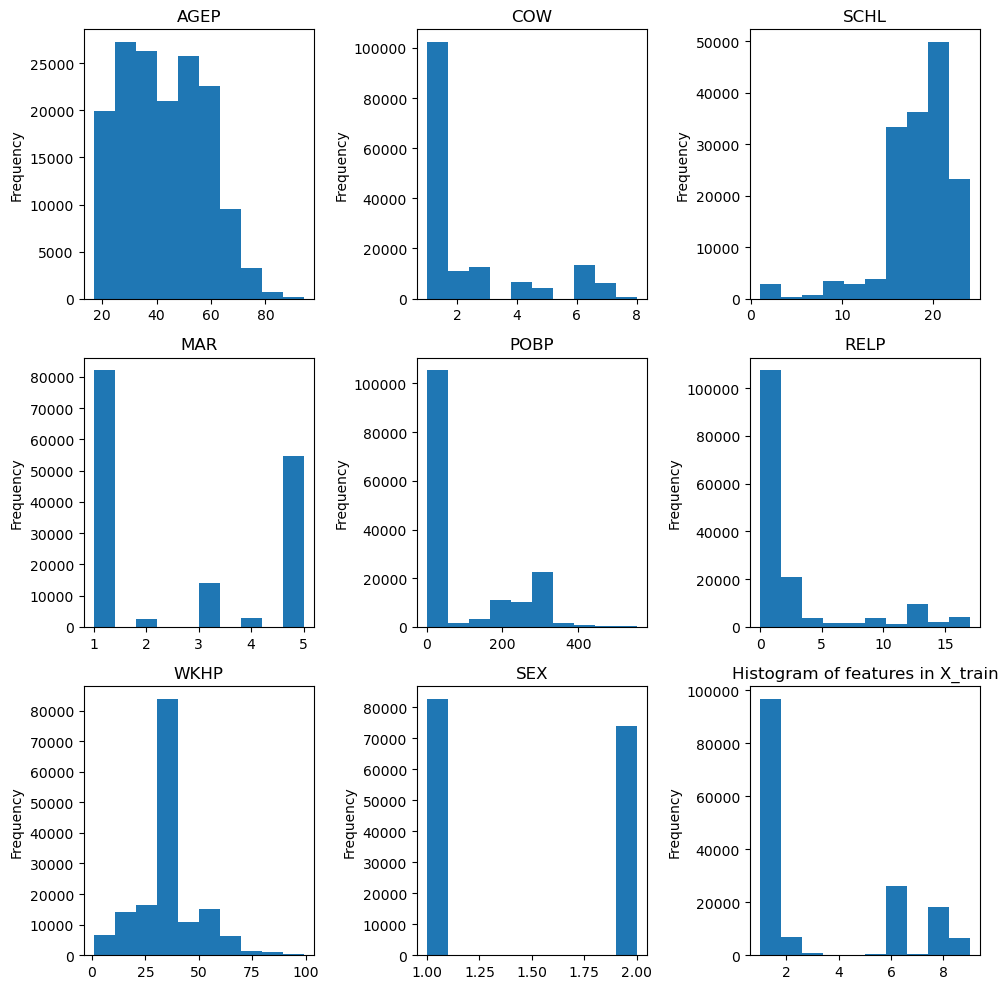

,AGEP,COW,SCHL,MAR,POBP,RELP,WKHP,SEX,RAC1P
count,156532.0000,156532.000000,156532.000000,156532.000000,156532.000000,156532.000000,156532.000000,156532.000000,156532.000000
mean,42.7448,2.144111,18.469035,2.654147,94.326847,2.503641,37.863185,1.471737,3.071915
std,14.8909,1.888192,3.942033,1.846824,123.497988,4.437141,13.037727,0.499202,2.915066


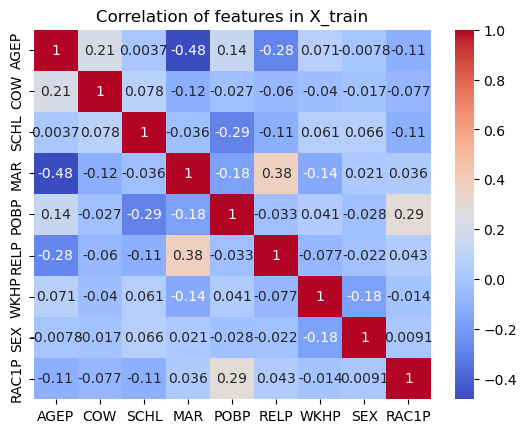

In [51]:
# make the target variable numeric
y_train['PINCP'] = y_train['PINCP'].replace({True: 1, False: 0})
y_test['PINCP'] = y_test['PINCP'].replace({True: 1, False: 0})

# make graph and table
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
axes = axes.flatten()

for i, feature in enumerate(feature_names):
    ax = axes[i]
    
    ax.hist(X_train[feature])
    ax.set_title(f'{feature}')
    ax.set_ylabel('Frequency')

fig.tight_layout()
plt.title('Histogram of features in X_train')
plt.show()


sns.heatmap(X_train.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation of features in X_train')

train_stats = X_train.describe().loc[['count','mean', 'std']]
train_stats


In [52]:
categorical = ['COW', 'SCHL', 'MAR', 'POBP', 'RELP', 'SEX', 'RAC1P']
numerical = ['AGEP', 'WKHP']

X_train[categorical] = X_train[categorical].astype('category')
X_test[categorical] = X_test[categorical].astype('category')
X_train[numerical] = X_train[numerical].astype(float)
X_test[numerical] = X_test[numerical].astype(float)

According to feature description and the graph I made, AGEP and WKHP should be numerical values and COW, SCHL, MAR, POBP, RELP, SEX, RAC1P should be categorical since there is no numerical relationship despite them being coded in integers.

## Part II: ML pipeline for a Classification Tree

Next, you'll build an ML pipeline using sklearn. Take some time to familiarize yourself with [sklearn.pipeline.Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) before proceeding.

### 2.1 Pre-processing of features

The first step of the pipeline will standardize the numeric features and one-hot encode the categorical features. Write the code for this preprocessing step below. 

**Hint**: Take a look at sklearn's ColumnTransformer, OneHotEncoder and StandardScaler for this task. 

In [53]:
preprocessor = ColumnTransformer(
    transformers=[
        ('stand', StandardScaler(), numerical),
        ('onehot', OneHotEncoder(handle_unknown = 'ignore'), categorical)])



### 2.2 Use your pre-processed data to fit a basic DecisionTreeClassifier

Now, bring together the pre-processing step with a Decision Tree Classifier in a pipeline. For now, use the default values; we'll take care of hyperparameter optimization later. Fit the pipeline on the training data. How deep is the resulting tree? How many leafs are in the tree? Print the 10 variables with highest feature importance and tell us what those importances mean in plain English. Plot the top 5 levels of the fitted decision tree. Make sure that the nodes are appropriately labeled. Comment on anything that you find interesting.

In [54]:
pipeline = Pipeline(steps=[('pre-processing', preprocessor),
                           ('fit-tree', DecisionTreeClassifier(random_state = 11))])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('pre-processing',
                 ColumnTransformer(transformers=[('stand', StandardScaler(),
                                                  ['AGEP', 'WKHP']),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['COW', 'SCHL', 'MAR', 'POBP',
                                                   'RELP', 'SEX', 'RAC1P'])])),
                ('fit-tree', DecisionTreeClassifier(random_state=11))])

In [55]:
tree_22 = pipeline.named_steps['fit-tree']
top10 = tree_22.feature_importances_.argsort()[::-1][:10]

print('The resulting tree is {} layers deep.'.format(tree_22.tree_.max_depth))
print('There are {} leaves.'.format(tree_22.tree_.n_leaves))
print('')
print('The 10 variables with highest feature importance are:')
for i in top10:
    print('{}:{}'.format(preprocessor.get_feature_names_out()[i], tree_22.feature_importances_[i]))

The resulting tree is 88 layers deep.
There are 37877 leaves.

The 10 variables with highest feature importance are:
stand__AGEP:0.23368390574491804
stand__WKHP:0.20106479553407527
onehot__POBP_303.0:0.04851191353603113
onehot__SCHL_21.0:0.03188493095286833
onehot__SCHL_22.0:0.02711601005941547
onehot__SCHL_16.0:0.024494038934455915
onehot__SCHL_23.0:0.018348242675692374
onehot__POBP_6.0:0.016631254584453234
onehot__COW_1.0:0.016345106686422
onehot__RELP_0.0:0.015876751185093668


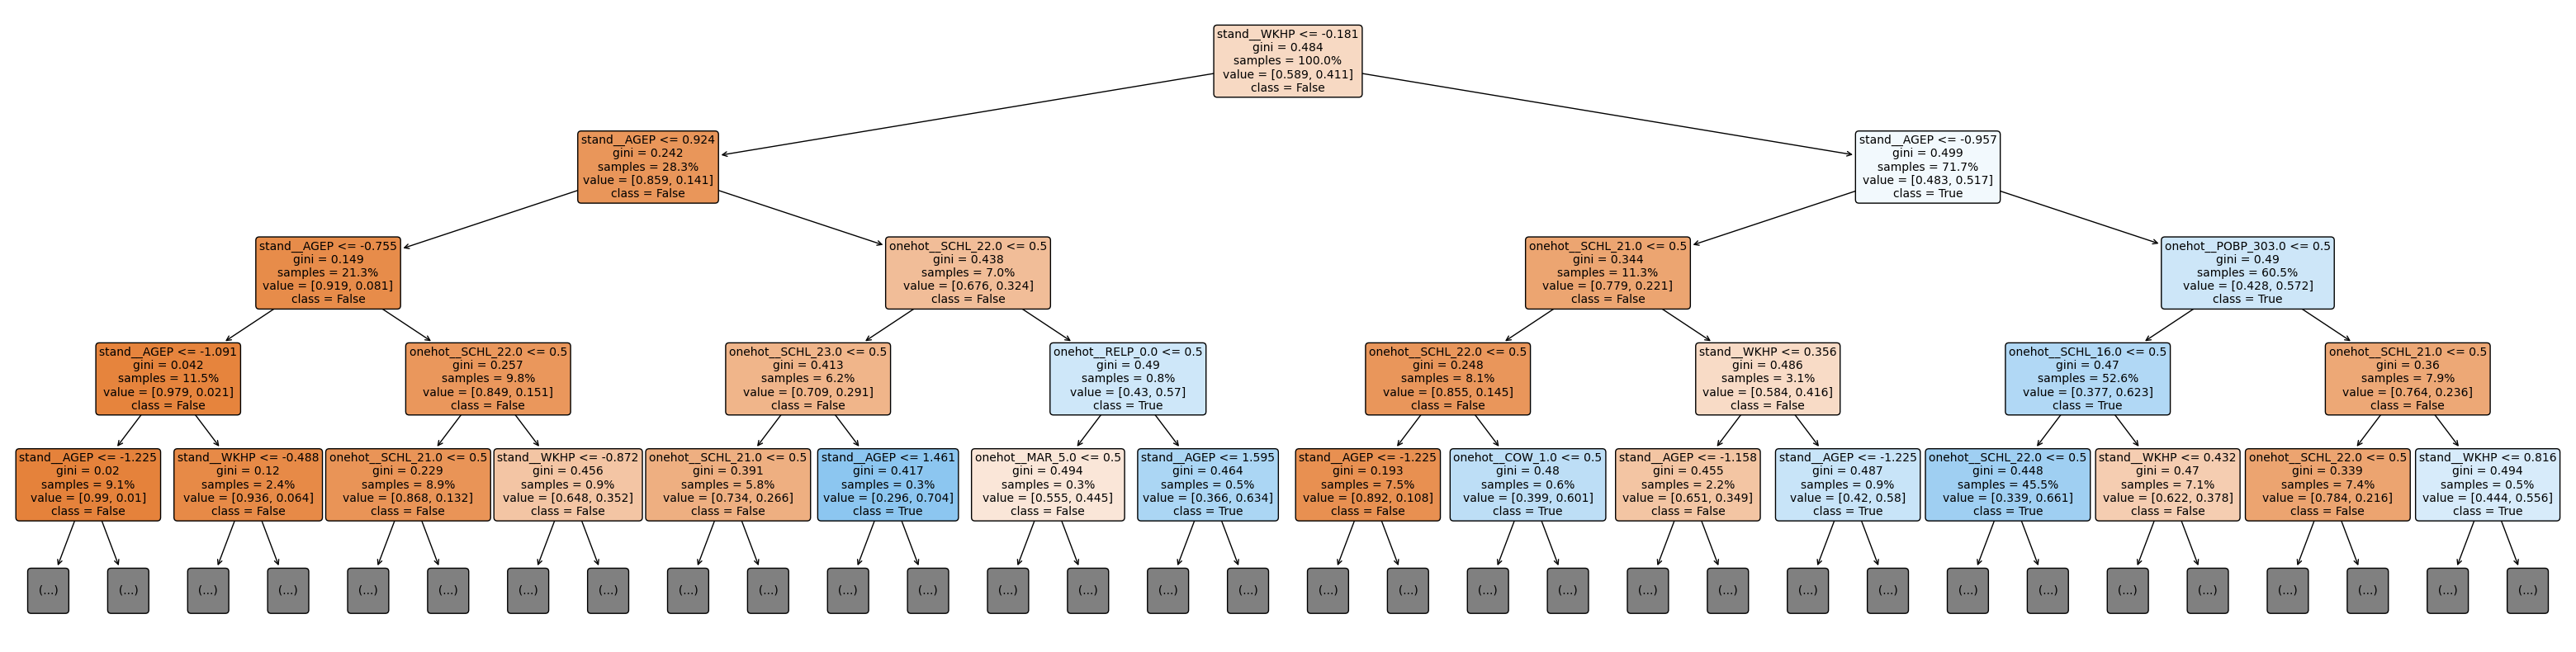

In [56]:
feature_names = preprocessor.get_feature_names_out().tolist()

plt.figure(figsize=(40, 10))
tree.plot_tree(tree_22, max_depth=4, feature_names=feature_names, 
               proportion=True, filled=True, rounded=True, class_names=['False', 'True'], fontsize= 10)
plt.show()


* The 10 variables with the highest feature importrance (in descending order) are standardize_num__AGEP, standardize_num__WKHP, onehot_cate__POBP_303.0, onehot_cate__SCHL_21.0, onehot_cate__SCHL_22.0, onehot_cate__SCHL_16.0, onehot_cate__SCHL_23.0, onehot_cate__POBP_6.0, onehot_cate__RELP_0.0, onehot_cate__COW_1.0, which are age; working hours; place of birth is mexico; level of education is bachelor; level of education is master; level of education is high school; level of education is professional degree beyond a bachelor; place of birth is california; reference person is self; is an employee of a private for-profit company or business.
Those importances value represent the relative contribution of each feature to the final decision of the tree.
* one interesting thing I noticed is that being born in CA influenced the income, meaning local people got different treatment compare to non-locals?

### 2.3 Estimate AUC using K-Fold CV

Calculate the 5-fold cross-validated AUC-ROC for this simple tree pipeline. Report the score for each fold as well as the average across all folds. 

**Hint 1**: sklearn.model_selection.cross_val_score is your friend. Setting the verbose option to 3 is useful. 

In [57]:
cv_scores = cross_val_score(pipeline, X_train, y_train, cv =5, scoring = 'roc_auc', verbose=3)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.737) total time=  13.3s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.3s remaining:    0.0s


[CV] END ................................ score: (test=0.738) total time=  13.3s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   26.7s remaining:    0.0s


[CV] END ................................ score: (test=0.737) total time=  12.1s
[CV] END ................................ score: (test=0.736) total time=  11.8s
[CV] END ................................ score: (test=0.737) total time=  12.2s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.1min finished


In [58]:

print('The score for each fold is {}'.format(cv_scores))
print('The average across all folds is {}'.format(cv_scores.mean()))

The score for each fold is [0.73665815 0.73767712 0.73700185 0.73649518 0.7372397 ]
The average across all folds is 0.7370144020470897


### 2.4 Estimating AUC using nested CV 

Let's try to improve on the results of the decision tree by tweaking its hyperparameters. Since you already are an expert using nested CV, this is going to be a walk in the park! Compute the nested cv AUC-ROC of a decision tree pipeline. Use 5 folds for the inner loop and 3 folds for the outer loop. Include different values for "max_depth", "max_features" and "max_leave_nodes" in your hyperparameter grid. Report the inner fold scores for all combinations of hyperparams.  Report the best hyperparams used in each outer fold along with their outer fold score. How stable are the results?

What else do you notice in these results? To what extent do you think specific hyperparameters might lead to overfitting? How is run-time impacted by your choice of hyperparameters? Is hyperparameter optimization worth the trouble?

**Hint 1**: The pipeline remains the same. You can access the list of all the hyperparams in your pipeline with pipeline.get_params_keys(). Notice the naming convention.

**Hint 2**: GridSearchCV and cross_val_score/cross_validate are your friends-- especially if you run them with verbose = 3.

**Hint 3**: This gets computationally expensive quickly. Be intelligent about the hyperparameter values you include in the grid and the number of outer and inner folds you use (we use 5 inner folds and 3 outer folds).

In [59]:

outer = 3
inner = 5

params = {
    'fit-tree__max_depth': [10,40,90],
    'fit-tree__max_features': [10,100,200],
    'fit-tree__max_leaf_nodes': [100,1000,10000]
}

best_param = GridSearchCV(pipeline, param_grid=params, scoring='roc_auc', n_jobs = -1, cv = inner, verbose = 3)
result = cross_validate(best_param,X_train, y_train, scoring='roc_auc', n_jobs = -1, cv = outer, verbose = 3,  return_estimator = True)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.0min finished


In [60]:
max_depth_list = [val for val in params['fit-tree__max_depth'] for i in range(9)]
max_features_list = [val for val in params['fit-tree__max_features'] for i in range(3)] * 3
max_leaf_list =  params['fit-tree__max_leaf_nodes'] * 9

inner_fold_scores = pd.DataFrame({
    'max_depth':max_depth_list,
    'max_features': max_features_list,
    'max_leaf_nodes': max_leaf_list,
    'fold 1': result['estimator'][0].cv_results_['mean_test_score'],
    'fold 2': result['estimator'][1].cv_results_['mean_test_score'],
    'fold 3': result['estimator'][2].cv_results_['mean_test_score']
})

outer_score = pd.DataFrame({
    'fold':['fold1', 'fold2', 'fold3'],
    'max_depth':[estimator.best_params_['fit-tree__max_depth'] for estimator in result['estimator']],
    'max_features':[estimator.best_params_['fit-tree__max_features'] for estimator in result['estimator']],
    'max_leaf_nodes':[estimator.best_params_['fit-tree__max_leaf_nodes'] for estimator in result['estimator']],
    'scores': result['test_score']
})
inner_fold_scores

,max_depth,max_features,max_leaf_nodes,fold 1,fold 2,fold 3
0,10,10,100,0.709341,0.744435,0.737035
1,10,10,1000,0.709424,0.746493,0.738685
2,10,10,10000,0.709424,0.746493,0.738685
3,10,100,100,0.847820,0.847118,0.844376
4,10,100,1000,0.846625,0.846622,0.844472
5,10,100,10000,0.846625,0.846622,0.844472
6,10,200,100,0.852363,0.851052,0.852600
7,10,200,1000,0.850341,0.848717,0.851010
8,10,200,10000,0.850341,0.848717,0.851010
9,40,10,100,0.760326,0.766508,0.767011


In [61]:
outer_score.set_index('fold')

,max_depth,max_features,max_leaf_nodes,scores
fold,,,,
fold1,40,200,100,0.857748
fold2,40,200,100,0.860971
fold3,40,200,1000,0.862159


* The results are fairly stable as we see that the best score is attained by the same hyperparam in fold1 and fold2, and only max_leaf_nodes changed in fold3 for the best score. 
* I noticed that both the max_depth and max_leaf_nodes lies within the param grid I gave, suggesting that the value is truly optimal for score, but the max_features param took maximum value of 200 for all 3 folds, meaning that we might want to extend the range of max_features in grid search and probably would lead to better score. 
* All three of the hyperparams would lead to overfitting if they are not limited, we could see that when max_depth exceeds 40; max_features exceeds 200 and max_leaf_nodes exceeds 100, the estimated performance decreases, due to overfitting. This is reasonable as we might end up with very few or even only one observation in each leaf node without adding constraint on max_depth/max_leaf_nodes, making our tree learn way too much from the noise of our training data and fail to generalize. 
* Choosing large value for the hyperparameters would increase the run-time.
* However, it is worth the trouble since our score also improves greatly: from .74 to .86.

## Part III: ML pipeline for a random forest

### 3.1 Bare bones random forest
Just as you did for the classification tree, start by training a bare bones random forest using your training data. We will take care of the hyperparameter optimization later, but for the time being, use a maximum tree depth of 15. Hopefully is it clear by now why this is a good idea, since we are going to be training a bunch of trees. You should continue to use the same preprocessing step as before. 

How many trees are in the forest? Which are the most important features? Compute the fraction of the trees that are splitting on age at their root node. Create a plot showing the 10 most important features and compare them to the results you obtained before. Explain the meaning of variable importance in the case of a random forest classifier.

In [62]:
pipeline_3 = Pipeline(steps=[('pre-processing', preprocessor),
                           ('fit_forest', RandomForestClassifier(max_depth=15, random_state = 11))])

pipeline_3.fit(X_train, y_train)

d:\Anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Pipeline(steps=[('pre-processing',
                 ColumnTransformer(transformers=[('stand', StandardScaler(),
                                                  ['AGEP', 'WKHP']),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['COW', 'SCHL', 'MAR', 'POBP',
                                                   'RELP', 'SEX', 'RAC1P'])])),
                ('fit_forest',
                 RandomForestClassifier(max_depth=15, random_state=11))])

In [63]:
forest = pipeline_3.named_steps['fit_forest']
top10_3 = forest.feature_importances_.argsort()[::-1][:10]

print('The number of tree in forest is {}.'.format(len(forest.estimators_)))
print('')
print('The 10 variables with highest feature importance are:')
for i in top10_3:
    print('{}:{}'.format(preprocessor.get_feature_names_out()[i], forest.feature_importances_[i]))

root_age_num = sum([estimator.tree_.feature[0] == 0 for estimator in forest.estimators_])
print('')
print('The fraction of the trees that are splitting on age at their root node is {}'.format(root_age_num/len(forest.estimators_)))

importance_comparison = pd.DataFrame({
    'rank': list(range(1,11)),
    'Random_forest':[preprocessor.get_feature_names_out()[i] for i in top10_3],
    'Decision_tree':[preprocessor.get_feature_names_out()[i] for i in top10],
})
importance_comparison.set_index('rank')

The number of tree in forest is 100.

The 10 variables with highest feature importance are:
stand__WKHP:0.18114891503713515
stand__AGEP:0.1019093465677874
onehot__SCHL_22.0:0.08016573862323892
onehot__RELP_0.0:0.06381390608347692
onehot__SCHL_21.0:0.06368027071201438
onehot__MAR_5.0:0.06024283255683741
onehot__MAR_1.0:0.04987983386078296
onehot__RELP_2.0:0.04072995492143669
onehot__SCHL_16.0:0.038097932476582066
onehot__POBP_303.0:0.03772017535948155

The fraction of the trees that are splitting on age at their root node is 0.06


,Random_forest,Decision_tree
rank,,
1,stand__WKHP,stand__AGEP
2,stand__AGEP,stand__WKHP
3,onehot__SCHL_22.0,onehot__POBP_303.0
4,onehot__RELP_0.0,onehot__SCHL_21.0
5,onehot__SCHL_21.0,onehot__SCHL_22.0
6,onehot__MAR_5.0,onehot__SCHL_16.0
7,onehot__MAR_1.0,onehot__SCHL_23.0
8,onehot__RELP_2.0,onehot__POBP_6.0
9,onehot__SCHL_16.0,onehot__COW_1.0


* We could see that while the ranking is a little different, most of the features that have top 10 feature importance remains in the top 10 of our random forest classifier. 
* The feature importance in the random forest means that they have the highest mean decrease of impurity across trees. (one problem using this metric as feature importance is that it overestimates the importance of continuous variable, which might be the reason why we see AGEP & WKHP as our top 2 variable in both tree and forest.)

### 3.2 Estimating AUC using K-fold CV 

Calculate the 5-fold cross-validated AUC-ROC for the random forests pipeline. Report the score for each fold as well as the average across all folds. 

**Hint 1**: sklearn.model_selection.cross_val_score is your friend. Setting the verbose option to 3 is useful. 


In [64]:
cv_scores_3 = cross_val_score(pipeline_3, X_train, y_train, cv =5, scoring = 'roc_auc', verbose=3, n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   36.0s remaining:   54.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   36.9s finished


In [65]:

print('The score for each fold is {}'.format(cv_scores_3))
print('The average across all folds is {}'.format(cv_scores_3.mean()))

The score for each fold is [0.86660736 0.87274228 0.871898   0.87230154 0.87309039]
The average across all folds is 0.8713279137031529


### 3.3 Estimating AUC using nested CV 

Let's try to improve on the results of the random forest by tweaking its hyperparameters. Build a pipeline that computes the nested cv AUC-ROC. Include different values for "n_estimators", "max_samples","max_features", "max_depth" and "max_leaf_nodes" in your hyperparameter grid. Report the inner fold scores for all combinations of hyperparams.  Report the best hyperparams used in each outer fold along with their outer fold score.

What do you notice about these results? How are these results related to those from the decision tree pipeline? Is hyperparameter optimization worth the trouble?

**Hint 1**: The pipeline remains the same. You can acces the list of all the hyperparams in your pipeline with pipeline.get_params_keys(). Notice the naming convention.

**Hint 2**: GridSearchCV and cross_val_score/cross_validae are your friends. Specially if you run them with verbose = 3.

**Hint 3**: This gets computationally expensive quickly. Be intelligent about the hyperparam values you include in the grid.

In [66]:
print('average num of leaf nodes is')
print(np.mean([estimator.tree_.n_leaves for estimator in forest.estimators_]))
print('num of total sample is')
print(len(X_train))

average num of leaf nodes is
1518.2
num of total sample is
156532


In [67]:

outer = 3
inner = 5

params = {
    'fit_forest__n_estimators': [50,150],
    'fit_forest__max_samples': [1000,10000],
    'fit_forest__max_depth': [10,20],
    'fit_forest__max_features': ['sqrt','log2'],
    'fit_forest__max_leaf_nodes': [1000,2000]
}

best_param_3 = GridSearchCV(pipeline_3, param_grid=params, scoring='roc_auc', n_jobs = -1, cv = inner, verbose = 3)
result_3 = cross_validate(best_param_3,X_train, y_train, scoring='roc_auc', n_jobs = -1, cv = outer, verbose = 3,  return_estimator = True)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  6.7min finished


In [68]:
max_estimator_list = [val for val in params['fit_forest__n_estimators'] for i in range(16)]
max_sample_list = [val for val in params['fit_forest__max_samples'] for i in range(8)] * 2
max_depth_list = [val for val in params['fit_forest__max_depth'] for i in range(4)] * 4
max_features_list = [val for val in params['fit_forest__max_features'] for i in range(2)] * 8
max_leaf_list =  params['fit_forest__max_leaf_nodes'] * 16

inner_fold_scores = pd.DataFrame({
    'max_estimator':max_estimator_list,
    'max_sample':max_sample_list,
    'max_depth':max_depth_list,
    'max_features': max_features_list,
    'max_leaf_nodes': max_leaf_list,
    'fold 1': result_3['estimator'][0].cv_results_['mean_test_score'],
    'fold 2': result_3['estimator'][1].cv_results_['mean_test_score'],
    'fold 3': result_3['estimator'][2].cv_results_['mean_test_score']
})

outer_score = pd.DataFrame({
    'fold':['fold1', 'fold2', 'fold3'],
    'max_estimator':[estimator.best_params_['fit_forest__n_estimators'] for estimator in result_3['estimator']],
    'max_sample':[estimator.best_params_['fit_forest__max_samples'] for estimator in result_3['estimator']],
    'max_depth':[estimator.best_params_['fit_forest__max_depth'] for estimator in result_3['estimator']],
    'max_features':[estimator.best_params_['fit_forest__max_features'] for estimator in result_3['estimator']],
    'max_leaf_nodes':[estimator.best_params_['fit_forest__max_leaf_nodes'] for estimator in result_3['estimator']],
    'scores': result_3['test_score']
})
inner_fold_scores

,max_estimator,max_sample,max_depth,max_features,max_leaf_nodes,fold 1,fold 2,fold 3
0,50,1000,10,sqrt,1000,0.859070,0.858710,0.858278
1,50,1000,10,sqrt,2000,0.863572,0.862873,0.862670
2,50,1000,10,log2,1000,0.863188,0.861959,0.861140
3,50,1000,10,log2,2000,0.865093,0.863592,0.863865
4,50,1000,20,sqrt,1000,0.859070,0.858710,0.858278
5,50,1000,20,sqrt,2000,0.863572,0.862873,0.862670
6,50,1000,20,log2,1000,0.863188,0.861959,0.861140
7,50,1000,20,log2,2000,0.865093,0.863592,0.863865
8,50,10000,10,sqrt,1000,0.849000,0.851835,0.850643
9,50,10000,10,sqrt,2000,0.857284,0.855273,0.855853


In [69]:
outer_score.set_index('fold')

,max_estimator,max_sample,max_depth,max_features,max_leaf_nodes,scores
fold,,,,,,
fold1,150,10000,20,sqrt,2000,0.873187
fold2,150,10000,20,sqrt,2000,0.875971
fold3,150,10000,20,sqrt,2000,0.875398


* The result is now very stable as the best hyperparameter is the same for all 3 outer folds. 
* We see that the results are better than that from the decision tree pipeline.
* However, I would not say that the optimization is worth the trouble as the increase in score from non-optimized random forest (0.871 -> 0.874) is not as much as the increase in the decision tree case, and the run time increased by more than 10 times over.

### 3.4 Take stock of parts II and III

What do you conclude from parts II and III? If you were to choose between a decision tree and a random forest for this classification task, what would be your choice and why?

From part II and III, we could see the following result:
* score-wise: optimized forest ~> forest ~> optimized tree >> tree
* runtime-wise: optimized forest >>> optimized tree > forest ~= tree

Consider both runtime and score, we could see that optimized decision tree and random forest is the better choices each with pros and cons. If my main goal is interpretability, I would choose optimized decision tree; if my main goal is higher score and lower usage of time/memory, I would choose non-optimized random forest.


## Part IV: Test data, ROC curves and fairness thresholds

Note that until now, we have not used the test data for any purpose. Let's now incorporate it into our analysis and use it to find a "fair" threshold value.

### 4.1 Find the optimal hyperparameters and fit a decision tree pipeline

Use all of your training data to find the optimal hyperparameters and fit a decision tree pipeline. Report the optimal hyperparameters. 

**Note:** Recall that nested cross-validation is only providing you with an estimate of the out-of-sample performance of the model finding procedure that involves hyperparameter optimization. At training time you should carry out the entire model finding procedure, including hyperparameter optimization. 

In [70]:
params = {
    'fit-tree__max_depth': [10,40,90],
    'fit-tree__max_features': [10,100,200],
    'fit-tree__max_leaf_nodes': [100,1000,10000]
}

gs = GridSearchCV(pipeline, param_grid=params, scoring='roc_auc', n_jobs = -1, cv = 5, verbose = 3)
gs.fit(X_train, y_train)

optimized_param = gs.best_params_
print('The optimal hyperparameters are: {}'.format(optimized_param))

Fitting 5 folds for each of 27 candidates, totalling 135 fits


The optimal hyperparameters are: {'fit-tree__max_depth': 40, 'fit-tree__max_features': 200, 'fit-tree__max_leaf_nodes': 1000}


### 4.2 Scores and the ROC curve

Use the fitted pipeline to compute score values for all instances in the test set. Show the distribution of the scores in a histogram. Additionally, compute the (FPR,TPR) combinations for all relevant threshold values and use them to plot the ROC curve in a different figure. Following the convention, include a dashed line along the diagonal. Remember to label the axes and to make the figures as polished as possible.

**Note 1**: You should NOT be using sklearn.metrics.auc or sklearn.metrics.RocCurveDisplay to calculate or display the ROC curve. Please code this part yourself.

Text(0.5, 1.0, 'Histogram of Decision Tree Prediction on Test Set')

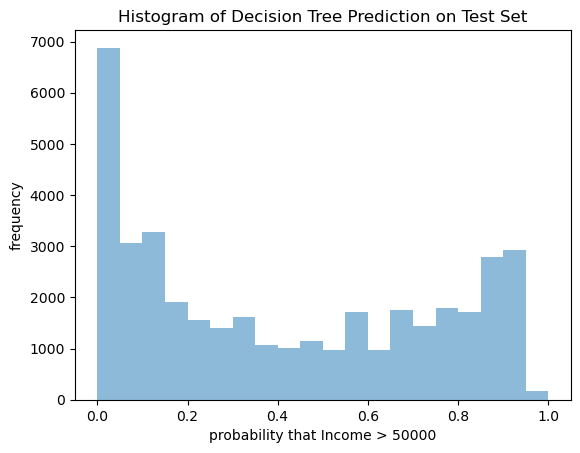

In [71]:
prob = gs.predict_proba(X_test)[:,1]
plt.hist(prob, alpha = 0.5, bins = 20)
plt.xlabel('probability that Income > 50000')
plt.ylabel('frequency')
plt.title('Histogram of Decision Tree Prediction on Test Set')

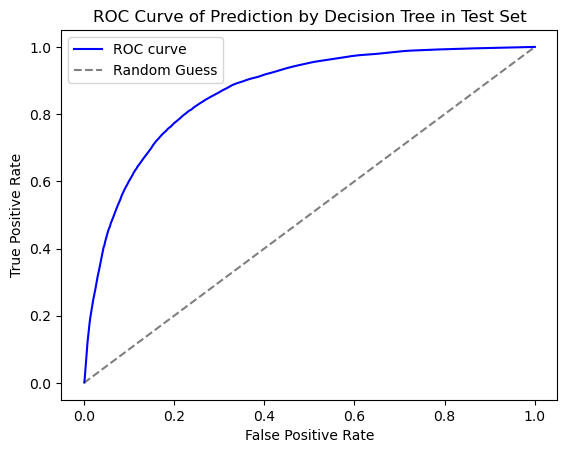

In [72]:
def compute_tpr_fpr(y_prob, y):
    thresholds = np.arange(0,1,0.01)
    tprs = []
    fprs = []
    for p in thresholds:
        y_pred = [y_prob >= p]
        tp = np.sum([y_pred & y])
        fp = np.sum([y_pred & ~y])
        tpr = tp/np.sum(y)
        fpr = fp/(len(y)-np.sum(y))
        tprs.append(tpr)
        fprs.append(fpr)
    return tprs, fprs

tprs, fprs = compute_tpr_fpr(prob, np.array(y_test).flatten())

plt.plot(fprs, tprs, color = 'blue', label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--', alpha = 0.5, label='Random Guess')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of Prediction by Decision Tree in Test Set')
plt.legend()
plt.show()


### 4.3  ROC curves by racial groups

Compute and plot in the same figure the ROC curves for the following racial groups identified by the ACS:

* White (RAC1P==1) (plot in blue)
* African American (RAC1P==2) (plot in orange)
* Asian American (RAC1P==6) (plot in green)

Interpret the results.

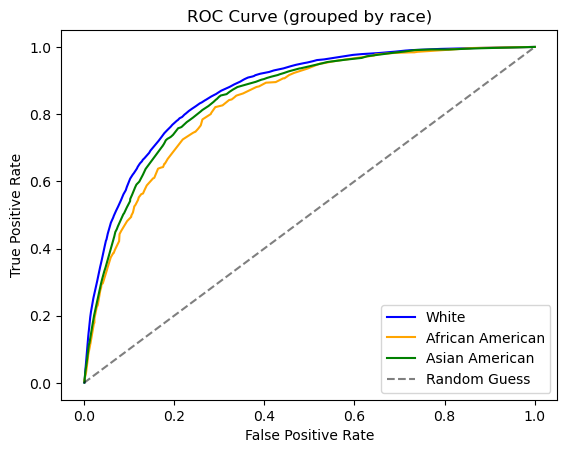

In [73]:
race_list = [1,2,6]
race_prob = []

for race in race_list:

    target = X_test['RAC1P']==race
    tprs, fprs = compute_tpr_fpr(prob[target], np.array(y_test[target]).flatten())
    race_prob.append([tprs,fprs])

plt.plot(race_prob[0][1], race_prob[0][0], color = 'blue', label='White')
plt.plot(race_prob[1][1], race_prob[1][0], color = 'orange', label='African American')
plt.plot(race_prob[2][1], race_prob[2][0], color = 'green', label='Asian American')
plt.plot([0, 1], [0, 1], 'k--', alpha = 0.5, label='Random Guess')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (grouped by race)')
plt.legend()
plt.show()

The graph clearly shows that the roc curve for White race is higher than that of Asian American race and is higher than that of African American race. It illustrates that under the same fpr, our decision tree correctly labels more white people than Asian Americans and African Americans. Which implies that it might have implicit bias: ceteris paribus, white people is more likely to earn >50000 compare to Asian American, and Asian American is more likely to earn >50000 than African American.

### 4.4 Achieving error parity

Implement a thresholding strategy that satisfies error parity for all racial groups with FPR = 0.3, TPR = 0.6 and $\epsilon$ = 0.025. In plain english, find a way of setting thresholds for the members of each group in the test data that, when evaluated on the test data, delivers FPR and TPR values that differ at most from the objective values by $\epsilon$.  Plot the estimated TPRs and FPRs of the racial groups in the ROC plot. Use star markers, colored accordingly. 

**Hint**: Consider using group-specific stochastic thresholds.

In [261]:
# generate a list of length n where each element is 1 with prob p and threshold with prob (1-p)
# this custom threshold would help us inflate or deflate both tpr and fpr
def generate_threshold_sequence(threshold, n, p):
    toReturn = []
    for i in range(n):
        if np.random.rand() < p:
            toReturn.append(1)
        else:
            toReturn.append(threshold)
    return toReturn

# a method that could calculate tpr, fpr with custom threshold vals
def get_tpr_fpr_adjusted_threshold(y_prob, y, threshold_val):
    y_pred = [y_prob >= threshold_val]
    tp = np.sum([y_pred & y])
    fp = np.sum([y_pred & ~y])
    tpr = tp/np.sum(y)
    fpr = fp/(len(y)-np.sum(y))

    return tpr, fpr


# find the threshold for each racial group that fpr/tpr = 0.5
race_list = [1,2,6]
race_index = []

for race in race_list:
    target = X_test['RAC1P']==race
    tprs, fprs = compute_tpr_fpr(prob[target], np.array(y_test[target]).flatten())
    ratio_list = [abs(fpr/tpr-0.5) for fpr,tpr in zip(fprs,tprs)]
    index = ratio_list.index(min(ratio_list))
    race_index.append(index)

epsilon = 0.025

# search for appropriate p s.t. tpr = 0.6
race_adjusted_rate = ['','','']
for p in np.arange(0.,1,0.01):
    for i in range(len(race_index)):
        tpr, fpr = get_tpr_fpr_adjusted_threshold(prob[X_test['RAC1P']==race_list[i]], 
                                                np.array(y_test[X_test['RAC1P']==race_list[i]]).flatten(), 
                                                generate_threshold_sequence(race_index[i]*0.01,sum(X_test['RAC1P']==race_list[i]) , p))
        if (abs(tpr-0.6) <= epsilon) & (abs(fpr-0.3)<= epsilon):
            race_adjusted_rate[i] = [tpr, fpr, p]


rate_table = pd.DataFrame({'tpr':[race_adjusted_rate[0][0],race_adjusted_rate[1][0],race_adjusted_rate[2][0]],
                           'fpr':[race_adjusted_rate[0][1],race_adjusted_rate[1][1],race_adjusted_rate[2][1]],
                           'corresponding p':[race_adjusted_rate[0][2],race_adjusted_rate[1][2],race_adjusted_rate[2][2]]
                           })
rate_table

,tpr,fpr,corresponding p
0,0.578623,0.290761,0.39
1,0.600644,0.295265,0.36
2,0.583280,0.281497,0.38


We could see that with the group specific thresholds, we could achieve error parity.

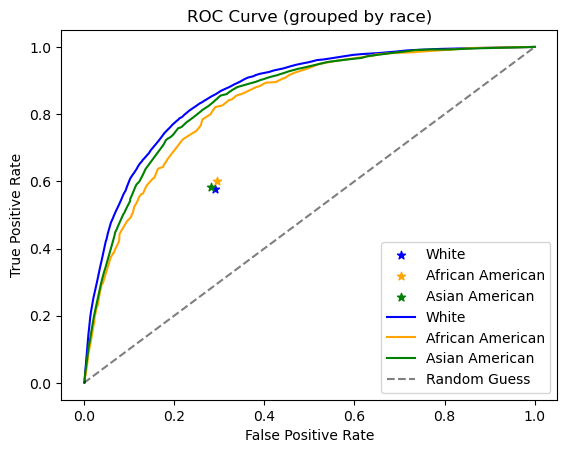

In [262]:

plt.scatter(race_adjusted_rate[0][1],race_adjusted_rate[0][0], color = 'blue', marker = "*",label='White')
plt.scatter(race_adjusted_rate[1][1],race_adjusted_rate[1][0], color = 'orange', marker = "*",label='African American')
plt.scatter(race_adjusted_rate[2][1],race_adjusted_rate[2][0], color = 'green', marker = "*",label='Asian American')

plt.plot(race_prob[0][1], race_prob[0][0], color = 'blue', label='White')
plt.plot(race_prob[1][1], race_prob[1][0], color = 'orange', label='African American')
plt.plot(race_prob[2][1], race_prob[2][0], color = 'green', label='Asian American')
plt.plot([0, 1], [0, 1], 'k--', alpha = 0.5, label='Random Guess')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (grouped by race)')
plt.legend()
plt.show()

### 4.5 Improving the results [extra-credit]

Can you improve the results from 4.4? That is, can you tweak your algorithm to deliver a higher TPR and lower FPR while still satisfying error parity with epsilon = 0.025? What is the best result that you are able to achieve? Is there a hard limit on how much you can improve?

*your observations here*

### 4.6 Conclusion

What can you say about welfare and error parity? Some things to consider:

* In this income prediction task, is enforcing error parity costly?
* Would you expect this results to generalize to other predictions problems?
* Is the group definition relevant?
* Who benefits from enforcing error parity? Who doesn't?

* In this income prediction task, not only enforcing error partiy require more compuation time, it also reduces the performance of model, it is costly.
* I would not expect this result to generalize to other prediciton problems. Firstly, the error is specific to this dataset; secondly, the bias in other prediction problems might vary in magnitude and direction, hence the generalizability is low.
* The group definition is relevant since it helps us assess how our model have implicit bias by comparing the roc curve between the 3 racial groups.
* In our case, African American racial group benefits from enforcing error parity, White racial group and Asian American racial group doesn't.